## K-Means Clustering

### Assignment 1 (2 scores):

- Generate a toy dataset having $600$ data points, $200$ points of them following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma)$, $200$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma)$, and $200$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma)$ where $\Sigma =
\left(\begin{array}{cc}
    1 & 0 \\
    0 & 1
\end{array}\right)
$.
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.
- Give comments on the effect of intializing centroids randomly to the overall performance of K-means.

Dịch:
- Tạo một tập dữ liệu mẫu gồm $600$ điểm dữ liệu, trong đó $200$ điểm tuân theo phân phối Gaussian $\mathcal{N}((2, 2), \Sigma)$, $200$ điểm tuân theo phân phối Gaussian $\mathcal{N}((8, 3), \Sigma)$, và $200$ điểm tuân theo phân phối Gaussian $\mathcal{N}((3, 6), \Sigma)$ với $\Sigma = \left(\begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array}\right)$.
- Chỉ sử dụng Numpy để cài đặt phương pháp K-means nhằm tìm ba cụm từ tập dữ liệu mẫu.
- Huấn luyện K-means này với phương pháp EM.
- Đưa ra nhận xét về ảnh hưởng của việc khởi tạo tâm cụm ngẫu nhiên đến hiệu suất tổng thể của K-means.

#### 1.1. Import thư viện

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Đặt seed để kết quả có thể tái tạo được
np.random.seed(42)

#### 1.2. Tạo dữ liệu mẫu

Tạo 600 điểm dữ liệu từ 3 phân phối Gaussian khác nhau.
- Sử dụng `np.random.multivariate_normal(mean, cov, size)` để sinh dữ liệu
- 3 tâm thực: (2,2), (8,3), (3,6)
- Ma trận hiệp phương sai Σ = I (ma trận đơn vị 2x2)
- Lưu lại nhãn thực (ground truth) để so sánh kết quả sau này.

In [2]:
# Định nghĩa các tham số phân phối Gaussian
mean1 = [2, 2]  # Tâm cụm 1
mean2 = [8, 3]  # Tâm cụm 2
mean3 = [3, 6]  # Tâm cụm 3
cov = [[1, 0], [0, 1]]  # Ma trận hiệp phương sai (ma trận đơn vị)

# Sinh dữ liệu từ 3 phân phối Gaussian
n_points = 200  # Số điểm mỗi cụm
X1 = np.random.multivariate_normal(mean1, cov, n_points)
X2 = np.random.multivariate_normal(mean2, cov, n_points)
X3 = np.random.multivariate_normal(mean3, cov, n_points)

# Ghép dữ liệu thành một mảng
X = np.vstack([X1, X2, X3])

# Tạo nhãn thực (ground truth) để so sánh sau
y_true = np.array([0]*n_points + [1]*n_points + [2]*n_points)

print(f"Kích thước dữ liệu: {X.shape}")
print(f"Số điểm mỗi cụm: {n_points}")

Kích thước dữ liệu: (600, 2)
Số điểm mỗi cụm: 200


#### 1.3. Trực quan hóa dữ liệu ban đầu

- Vẽ scatter plot để quan sát phân bố dữ liệu.
- Quan sát xem các cụm có tách biệt rõ ràng không.

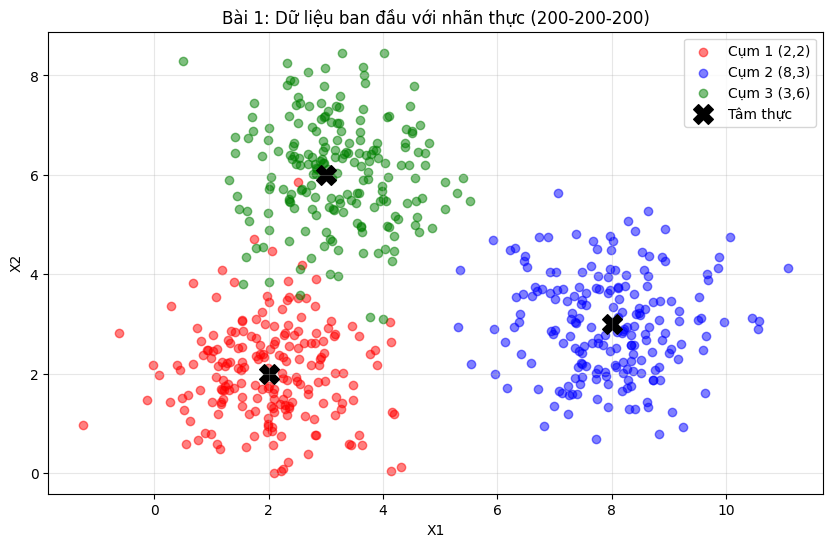

In [3]:
plt.figure(figsize=(10, 6))

# Vẽ các điểm dữ liệu theo nhãn thực
plt.scatter(X1[:, 0], X1[:, 1], c="red", alpha=0.5, label="Cụm 1 (2,2)")
plt.scatter(X2[:, 0], X2[:, 1], c="blue", alpha=0.5, label="Cụm 2 (8,3)")
plt.scatter(X3[:, 0], X3[:, 1], c="green", alpha=0.5, label="Cụm 3 (3,6)")

# Đánh dấu tâm thực
true_centers = np.array([mean1, mean2, mean3])
plt.scatter(true_centers[:, 0], true_centers[:, 1], c="black", marker="X", s=200, label="Tâm thực")

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Bài 1: Dữ liệu ban đầu với nhãn thực (200-200-200)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### 1.4. Cài đặt các hàm thành phần của K-means

Cài đặt các hàm cơ bản cho thuật toán K-means bằng Numpy
- `kmeans_init_centroids(X, k)`: Chọn ngẫu nhiên k điểm từ X làm tâm ban đầu
- `kmeans_compute_distance(X, centroids)`: Tính khoảng cách Euclidean
- `kmeans_assign_labels(X, centroids)`: Gán nhãn (E-step)
- `kmeans_update_centroids(X, labels, K)`: Cập nhật tâm (M-step)
- `has_converged()`: Kiểm tra hội tụ

In [4]:
def kmeans_init_centroids(X, k):
    """Khởi tạo ngẫu nhiên k tâm cụm từ dữ liệu X."""
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices].copy()


def kmeans_compute_distance(X, centroids):
    """Tính khoảng cách Euclidean từ mỗi điểm đến tất cả các tâm."""
    # Sử dụng broadcasting: (N, 1, D) - (1, k, D) = (N, k, D)
    diff = X[:, np.newaxis, :] - centroids[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff ** 2, axis=2))
    return distances


def kmeans_assign_labels(X, centroids):
    """E-step: Gán nhãn cho mỗi điểm dựa trên tâm cụm gần nhất."""
    distances = kmeans_compute_distance(X, centroids)
    labels = np.argmin(distances, axis=1)
    return labels


def kmeans_update_centroids(X, labels, K):
    """M-step: Cập nhật tâm cụm = trung bình các điểm trong cụm."""
    D = X.shape[1]
    new_centroids = np.zeros((K, D))
    for k in range(K):
        Xk = X[labels == k]
        if len(Xk) > 0:
            new_centroids[k] = np.mean(Xk, axis=0)
    return new_centroids


def has_converged(centroids, new_centroids, tol=1e-6):
    """Kiểm tra thuật toán đã hội tụ chưa."""
    shift = np.sqrt(np.sum((centroids - new_centroids) ** 2))
    return shift < tol


def compute_inertia(X, labels, centroids):
    """Tính hàm mục tiêu J (inertia) của K-means."""
    inertia = 0
    for i in range(len(centroids)):
        Xk = X[labels == i]
        inertia += np.sum((Xk - centroids[i]) ** 2)
    return inertia


print("Đã định nghĩa các hàm thành phần của K-means!")

Đã định nghĩa các hàm thành phần của K-means!


#### 1.5. Thuật toán K-means chính (Main Loop)

Cài đặt vòng lặp chính của thuật toán K-means theo phương pháp EM.
- Bước 1: Khởi tạo ngẫu nhiên K tâm cụm
- Bước 2 (E-step): Gán nhãn cho mỗi điểm
- Bước 3 (M-step): Cập nhật tâm cụm
- Bước 4: Lặp lại cho đến khi hội tụ

Đặt giới hạn số vòng lặp tối đa để tránh vòng lặp vô hạn.

In [5]:
def kmeans(X, K, max_iters=100, verbose=True):
    """
    Thuật toán K-means clustering.

    Parameters:
        X: numpy array shape (N, D) - dữ liệu đầu vào
        K: int - số cụm
        max_iters: int - số vòng lặp tối đa
        verbose: bool - in thông tin quá trình
    Returns:
        centroids_history, labels_history, n_iters
    """
    # Bước 1: Khởi tạo ngẫu nhiên K tâm cụm
    centroids = kmeans_init_centroids(X, K)
    centroids_history = [centroids.copy()]
    labels_history = []

    for i in range(max_iters):
        # Bước 2 (E-step): Gán nhãn
        labels = kmeans_assign_labels(X, centroids)
        labels_history.append(labels.copy())

        # Bước 3 (M-step): Cập nhật tâm cụm
        new_centroids = kmeans_update_centroids(X, labels, K)

        # Kiểm tra hội tụ
        if has_converged(centroids, new_centroids):
            if verbose:
                print(f"Hội tụ sau {i + 1} vòng lặp!")
            centroids_history.append(new_centroids.copy())
            return centroids_history, labels_history, i + 1

        centroids = new_centroids.copy()
        centroids_history.append(centroids.copy())

    if verbose:
        print(f"Đạt số vòng lặp tối đa: {max_iters}")
    return centroids_history, labels_history, max_iters


print("Đã định nghĩa hàm kmeans chính!")

Đã định nghĩa hàm kmeans chính!


#### 1.6. Chạy thuật toán K-means

**Mô tả:** Áp dụng thuật toán K-means đã cài đặt lên dữ liệu mẫu.

**Lưu ý:** Kết quả có thể khác nhau mỗi lần chạy do khởi tạo ngẫu nhiên.

In [6]:
# Chạy thuật toán K-means với K=3
K = 3
centroids_history, labels_history, n_iters = kmeans(X, K)

# Lấy kết quả cuối cùng
final_centroids = centroids_history[-1]
final_labels = labels_history[-1]

print(f"\nSố vòng lặp: {n_iters}")
print(f"\nTâm cụm tìm được:\n{final_centroids}")
print(f"\nTâm thực:\n{true_centers}")
print(f"\nInertia (J): {compute_inertia(X, final_labels, final_centroids):.2f}")

Hội tụ sau 7 vòng lặp!

Số vòng lặp: 7

Tâm cụm tìm được:
[[7.93924027 2.98407134]
 [3.1984887  6.11049523]
 [2.0191059  2.03147588]]

Tâm thực:
[[2 2]
 [8 3]
 [3 6]]

Inertia (J): 1121.86


#### 1.7. Trực quan hóa kết quả phân cụm

- Vẽ biểu đồ so sánh kết quả phân cụm với dữ liệu gốc.
- Lưu ý: Màu sắc của các cụm có thể không khớp với nhãn thực.

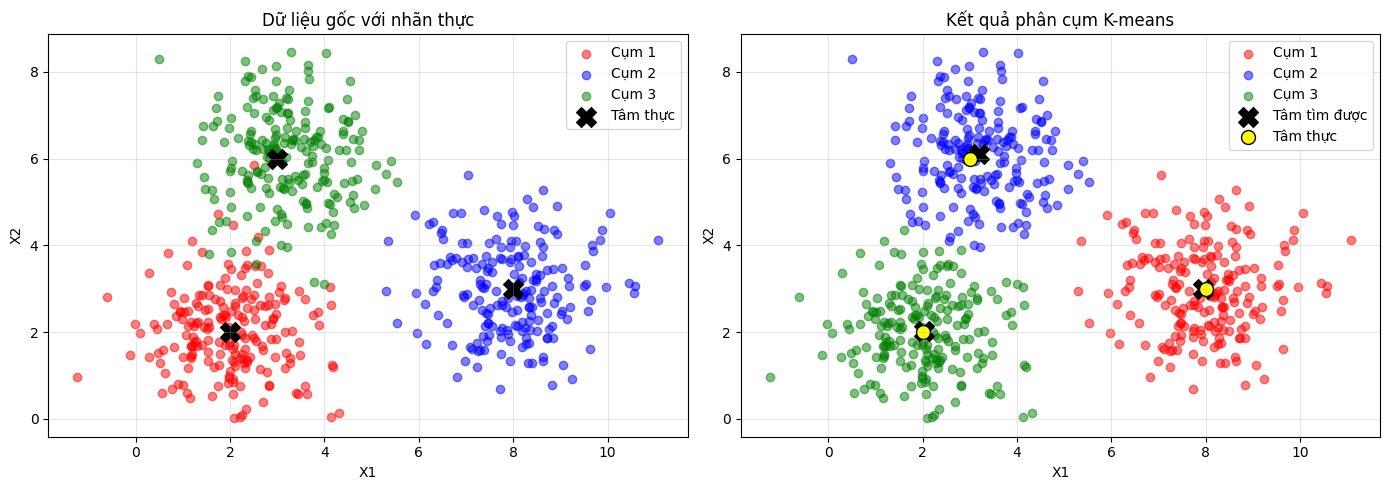

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ["red", "blue", "green"]

# Subplot 1: Dữ liệu gốc với nhãn thực
ax1 = axes[0]
for i in range(K):
    mask = y_true == i
    ax1.scatter(X[mask, 0], X[mask, 1], c=colors[i], alpha=0.5, label=f"Cụm {i+1}")
ax1.scatter(true_centers[:, 0], true_centers[:, 1], c="black", marker="X", s=200, label="Tâm thực")
ax1.set_xlabel("X1")
ax1.set_ylabel("X2")
ax1.set_title("Dữ liệu gốc với nhãn thực")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: Kết quả phân cụm K-means
ax2 = axes[1]
for i in range(K):
    mask = final_labels == i
    ax2.scatter(X[mask, 0], X[mask, 1], c=colors[i], alpha=0.5, label=f"Cụm {i+1}")
ax2.scatter(final_centroids[:, 0], final_centroids[:, 1], c="black", marker="X", s=200, label="Tâm tìm được")
ax2.scatter(true_centers[:, 0], true_centers[:, 1], c="yellow", marker="o", s=100, edgecolors="black", label="Tâm thực")
ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
ax2.set_title("Kết quả phân cụm K-means")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 1.8. Đánh giá ảnh hưởng của khởi tạo ngẫu nhiên
Chạy K-means nhiều lần với các khởi tạo khác nhau.
- Chạy K-means 20 lần với seed khác nhau
- Tính hàm mục tiêu J (inertia) cho mỗi lần chạy


In [8]:
# Chạy K-means nhiều lần với các seed khác nhau
n_runs = 20
results_ex1 = []

print("Chạy K-means 20 lần với khởi tạo ngẫu nhiên khác nhau...\n")

for run in range(n_runs):
    np.random.seed(run)
    cent_hist, lab_hist, n_iter = kmeans(X, K, verbose=False)

    final_cent = cent_hist[-1]
    final_lab = lab_hist[-1]
    inertia = compute_inertia(X, final_lab, final_cent)

    results_ex1.append({
        "run": run + 1,
        "n_iters": n_iter,
        "inertia": inertia,
        "centroids": final_cent
    })

# Hiển thị kết quả
print(f"{'Lần chạy':^10} | {'Số vòng lặp':^12} | {'Inertia (J)':^15}")
print("=" * 45)
for r in results_ex1:
    print(f"{r['run']:^10} | {r['n_iters']:^12} | {r['inertia']:^15.2f}")

Chạy K-means 20 lần với khởi tạo ngẫu nhiên khác nhau...

 Lần chạy  | Số vòng lặp  |   Inertia (J)  
    1      |      5       |     1121.86    
    2      |      8       |     1121.86    
    3      |      8       |     1121.86    
    4      |      5       |     1121.84    
    5      |      4       |     1121.86    
    6      |      6       |     1121.86    
    7      |      10      |     1121.86    
    8      |      5       |     1121.84    
    9      |      7       |     1121.84    
    10     |      5       |     1121.86    
    11     |      5       |     1121.84    
    12     |      12      |     2785.82    
    13     |      6       |     2785.82    
    14     |      7       |     1121.86    
    15     |      6       |     1121.86    
    16     |      4       |     1121.86    
    17     |      5       |     1121.84    
    18     |      3       |     1121.84    
    19     |      8       |     1121.86    
    20     |      7       |     1121.86    


In [9]:
# Thống kê kết quả
inertias_ex1 = [r["inertia"] for r in results_ex1]
n_iters_ex1 = [r["n_iters"] for r in results_ex1]

print("THỐNG KÊ KẾT QUẢ BÀI 1:")
print(f"Inertia - Min: {min(inertias_ex1):.2f}, Max: {max(inertias_ex1):.2f}, Mean: {np.mean(inertias_ex1):.2f}, Std: {np.std(inertias_ex1):.2f}")
print(f"Số vòng lặp - Min: {min(n_iters_ex1)}, Max: {max(n_iters_ex1)}, Mean: {np.mean(n_iters_ex1):.1f}")

# Tìm lần chạy tốt nhất và tệ nhất
best_run_ex1 = min(results_ex1, key=lambda x: x["inertia"])
worst_run_ex1 = max(results_ex1, key=lambda x: x["inertia"])

print(f"\nLần chạy tốt nhất: Run {best_run_ex1['run']} với Inertia = {best_run_ex1['inertia']:.2f}")
print(f"Lần chạy tệ nhất: Run {worst_run_ex1['run']} với Inertia = {worst_run_ex1['inertia']:.2f}")

THỐNG KÊ KẾT QUẢ BÀI 1:
Inertia - Min: 1121.84, Max: 2785.82, Mean: 1288.25, Std: 499.19
Số vòng lặp - Min: 3, Max: 12, Mean: 6.3

Lần chạy tốt nhất: Run 4 với Inertia = 1121.84
Lần chạy tệ nhất: Run 12 với Inertia = 2785.82


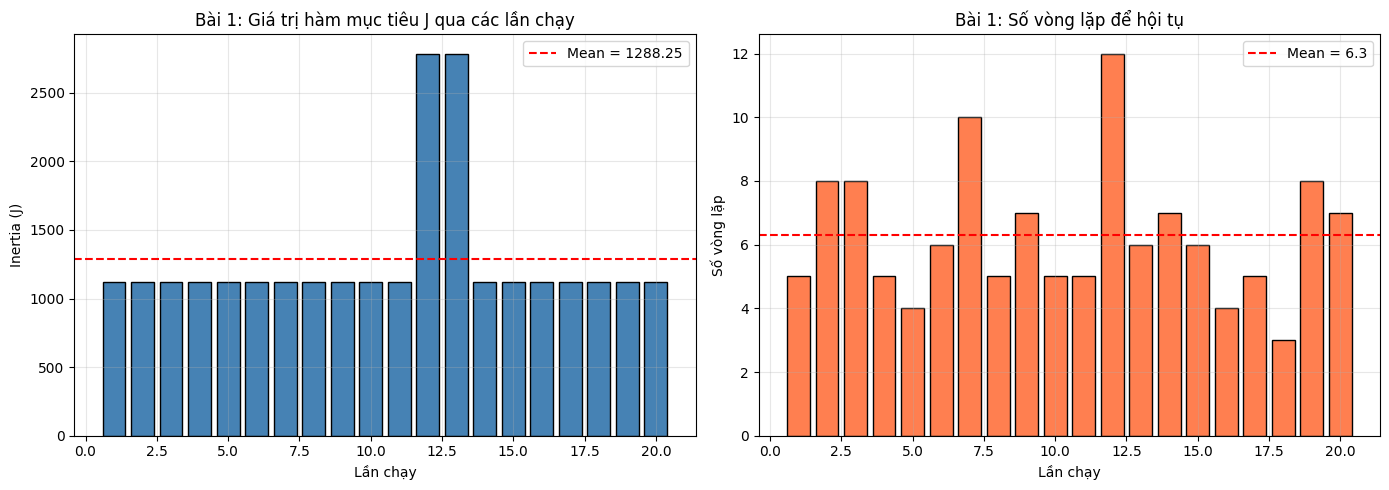

In [10]:
# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ Inertia
ax1 = axes[0]
ax1.bar(range(1, n_runs + 1), inertias_ex1, color="steelblue", edgecolor="black")
ax1.axhline(y=np.mean(inertias_ex1), color="red", linestyle="--", label=f"Mean = {np.mean(inertias_ex1):.2f}")
ax1.set_xlabel("Lần chạy")
ax1.set_ylabel("Inertia (J)")
ax1.set_title("Bài 1: Giá trị hàm mục tiêu J qua các lần chạy")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Biểu đồ số vòng lặp
ax2 = axes[1]
ax2.bar(range(1, n_runs + 1), n_iters_ex1, color="coral", edgecolor="black")
ax2.axhline(y=np.mean(n_iters_ex1), color="red", linestyle="--", label=f"Mean = {np.mean(n_iters_ex1):.1f}")
ax2.set_xlabel("Lần chạy")
ax2.set_ylabel("Số vòng lặp")
ax2.set_title("Bài 1: Số vòng lặp để hội tụ")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 1.9. Nhận xét về ảnh hưởng của khởi tạo ngẫu nhiên



1. **Ảnh hưởng đến giá trị hàm mục tiêu J (Inertia):**
   - Giá trị J dao động trong khoảng rất rộng: từ 1121.84 (tốt nhất) đến 2785.82 (tệ nhất)
   - Độ lệch chuẩn Std = 499.19 cho thấy sự biến động lớn giữa các lần chạy
   - Tuy nhiên, 18/20 lần chạy (90%) đạt kết quả tối ưu toàn cục (J ≈ 1121.84-1121.86)
   - Chỉ 2/20 lần (Run 12, 13) rơi vào cực tiểu địa phương với J = 2785.82 (gấp ~2.5 lần)

2. **Ảnh hưởng đến tốc độ hội tụ:**
   - Số vòng lặp dao động từ 3 đến 12, trung bình 6.3 vòng
   - Khởi tạo tốt giúp hội tụ nhanh hơn (Run 18 chỉ cần 3 vòng)
   - Khởi tạo xấu có thể cần nhiều vòng lặp hơn (Run 12 cần 12 vòng)

3. **Ảnh hưởng đến chất lượng phân cụm:**
   - Các lần chạy tốt (J ≈ 1121): Tâm cụm tìm được rất gần tâm thực, phân cụm chính xác
   - Các lần chạy tệ (J ≈ 2785): Thuật toán hội tụ về cực tiểu địa phương, có thể gộp 2 cụm gần nhau (Cụm 1 và 3) thành 1

4. **Kết luận:**
   - Khởi tạo ngẫu nhiên **có ảnh hưởng đáng kể** đến kết quả K-means (10% xác suất rơi vào local minimum)
   - Với dữ liệu có các cụm tách biệt rõ ràng, K-means vẫn có xác suất cao tìm được nghiệm tối ưu
   - **Giải pháp:** Sử dụng K-means++ để khởi tạo thông minh hơn, hoặc chạy nhiều lần và chọn kết quả có Inertia nhỏ nhất

### Assignment 2 (2 scores):
- Generate a toy dataset having $50$ points following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma)$, $20$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma)$, and $1000$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma)$ where $\Sigma =
\left(\begin{array}{cc}
    1 & 0 \\
    0 & 1
\end{array}\right)
$.
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.
- Give comments on the effect of different sizes among clusters to the performance of K-means.

Dịch:
- Tạo một tập dữ liệu mẫu gồm $50$ điểm tuân theo phân phối Gaussian $\mathcal{N}((2, 2), \Sigma)$, $20$ điểm tuân theo phân phối Gaussian $\mathcal{N}((8, 3), \Sigma)$, và $1000$ điểm tuân theo phân phối Gaussian $\mathcal{N}((3, 6), \Sigma)$ với $\Sigma = \left(\begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array}\right)$.
- Chỉ sử dụng Numpy để cài đặt phương pháp K-means nhằm tìm ba cụm từ tập dữ liệu mẫu.
- Huấn luyện K-means này với phương pháp EM.
- Đưa ra nhận xét về ảnh hưởng của sự khác biệt kích thước giữa các cụm đến hiệu suất của K-means.

#### 2.1. Tạo dữ liệu mẫu (Imbalanced Clusters)

Tạo dữ liệu với kích thước cụm không cân bằng: 50 + 20 + 1000 điểm.
- Cụm 1: 50 điểm
- Cụm 2: 20 điểm
- Cụm 3: 1000 điểm

K-means có thể bị bias về phía cụm lớn.

In [11]:
# Reset seed
np.random.seed(42)

# Định nghĩa các tham số - GIỐNG BÀI 1
mean1_ex2 = [2, 2]
mean2_ex2 = [8, 3]
mean3_ex2 = [3, 6]
cov_ex2 = [[1, 0], [0, 1]]

# Sinh dữ liệu với kích thước KHÔNG CÂN BẰNG
n1_ex2 = 50    # Cụm 1: 50 điểm
n2_ex2 = 20    # Cụm 2: 20 điểm
n3_ex2 = 1000  # Cụm 3: 1000 điểm

X1_ex2 = np.random.multivariate_normal(mean1_ex2, cov_ex2, n1_ex2)
X2_ex2 = np.random.multivariate_normal(mean2_ex2, cov_ex2, n2_ex2)
X3_ex2 = np.random.multivariate_normal(mean3_ex2, cov_ex2, n3_ex2)

# Ghép dữ liệu
X_ex2 = np.vstack([X1_ex2, X2_ex2, X3_ex2])

# Nhãn thực
y_true_ex2 = np.array([0]*n1_ex2 + [1]*n2_ex2 + [2]*n3_ex2)

print(f"Kích thước dữ liệu: {X_ex2.shape}")
print(f"Số điểm mỗi cụm: Cụm 1 = {n1_ex2}, Cụm 2 = {n2_ex2}, Cụm 3 = {n3_ex2}")
print(f"Tỷ lệ: {n1_ex2}:{n2_ex2}:{n3_ex2}")

Kích thước dữ liệu: (1070, 2)
Số điểm mỗi cụm: Cụm 1 = 50, Cụm 2 = 20, Cụm 3 = 1000
Tỷ lệ: 50:20:1000


#### 2.2. Trực quan hóa dữ liệu ban đầu

**Lưu ý:** Quan sát cụm 3 (màu xanh lá) chiếm ưu thế về số lượng.

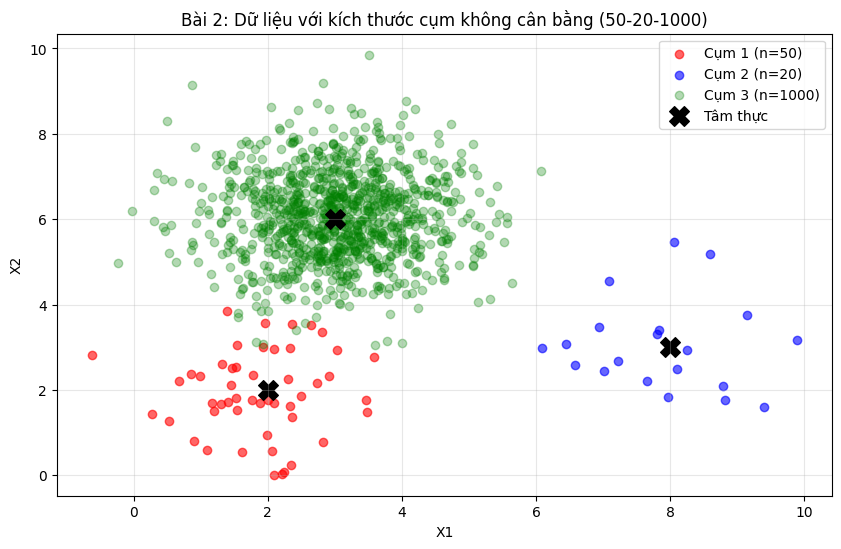

In [12]:
plt.figure(figsize=(10, 6))

# Vẽ các điểm dữ liệu
plt.scatter(X1_ex2[:, 0], X1_ex2[:, 1], c="red", alpha=0.6, label=f"Cụm 1 (n={n1_ex2})")
plt.scatter(X2_ex2[:, 0], X2_ex2[:, 1], c="blue", alpha=0.6, label=f"Cụm 2 (n={n2_ex2})")
plt.scatter(X3_ex2[:, 0], X3_ex2[:, 1], c="green", alpha=0.3, label=f"Cụm 3 (n={n3_ex2})")

# Đánh dấu tâm thực
true_centers_ex2 = np.array([mean1_ex2, mean2_ex2, mean3_ex2])
plt.scatter(true_centers_ex2[:, 0], true_centers_ex2[:, 1], c="black", marker="X", s=200, label="Tâm thực")

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Bài 2: Dữ liệu với kích thước cụm không cân bằng (50-20-1000)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### 2.3. Chạy thuật toán K-means

- Sử dụng lại các hàm đã định nghĩa ở Bài 1.

In [13]:
# Chạy K-means
np.random.seed(42)
K = 3
cent_hist_ex2, lab_hist_ex2, n_iters_ex2 = kmeans(X_ex2, K)

# Kết quả cuối cùng
final_centroids_ex2 = cent_hist_ex2[-1]
final_labels_ex2 = lab_hist_ex2[-1]

print(f"\nSố vòng lặp: {n_iters_ex2}")
print(f"\nTâm cụm tìm được:\n{final_centroids_ex2}")
print(f"\nTâm thực:\n{true_centers_ex2}")
print(f"\nInertia (J): {compute_inertia(X_ex2, final_labels_ex2, final_centroids_ex2):.2f}")

# Đếm số điểm trong mỗi cụm tìm được
print(f"\nSố điểm trong mỗi cụm tìm được:")
for i in range(K):
    print(f"  Cụm {i+1}: {np.sum(final_labels_ex2 == i)} điểm")

Hội tụ sau 14 vòng lặp!

Số vòng lặp: 14

Tâm cụm tìm được:
[[3.37199813 3.01494961]
 [2.38516541 5.79869154]
 [3.7477644  6.57612327]]

Tâm thực:
[[2 2]
 [8 3]
 [3 6]]

Inertia (J): 1918.18

Số điểm trong mỗi cụm tìm được:
  Cụm 1: 122 điểm
  Cụm 2: 499 điểm
  Cụm 3: 449 điểm


#### 2.4. Trực quan hóa kết quả phân cụm
- Quan sát xem K-means có phân cụm đúng không khi kích thước cụm chênh lệch lớn.

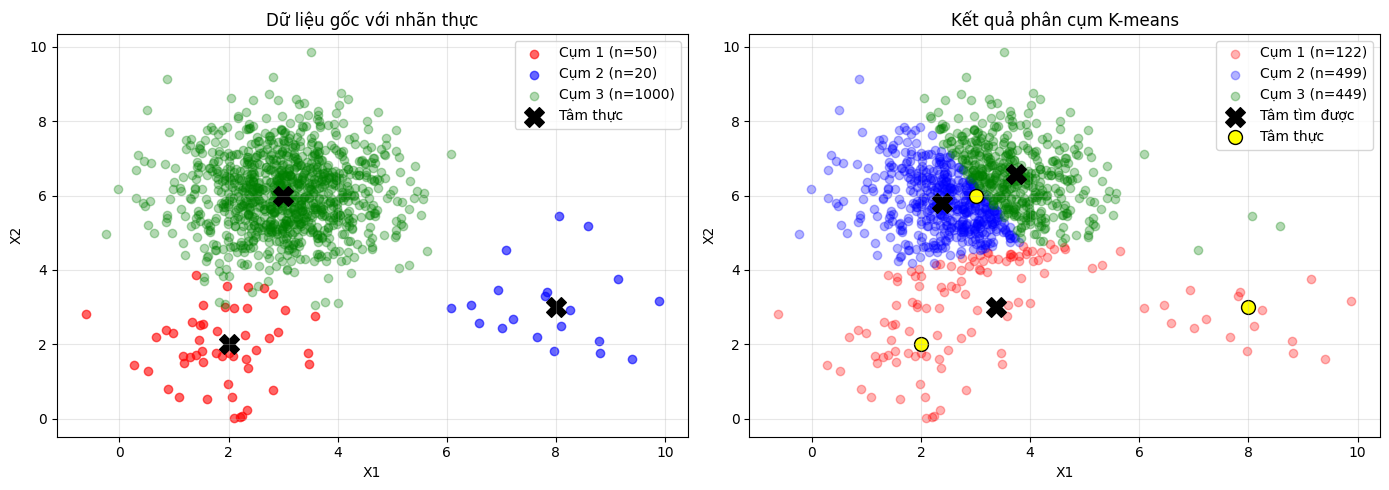

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ["red", "blue", "green"]

# Subplot 1: Dữ liệu gốc
ax1 = axes[0]
for i, (Xi, ni) in enumerate([(X1_ex2, n1_ex2), (X2_ex2, n2_ex2), (X3_ex2, n3_ex2)]):
    alpha = 0.3 if ni > 100 else 0.6
    ax1.scatter(Xi[:, 0], Xi[:, 1], c=colors[i], alpha=alpha, label=f"Cụm {i+1} (n={ni})")
ax1.scatter(true_centers_ex2[:, 0], true_centers_ex2[:, 1], c="black", marker="X", s=200, label="Tâm thực")
ax1.set_xlabel("X1")
ax1.set_ylabel("X2")
ax1.set_title("Dữ liệu gốc với nhãn thực")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: Kết quả K-means
ax2 = axes[1]
for i in range(K):
    mask = final_labels_ex2 == i
    n_cluster = np.sum(mask)
    alpha = 0.3 if n_cluster > 100 else 0.6
    ax2.scatter(X_ex2[mask, 0], X_ex2[mask, 1], c=colors[i], alpha=alpha, label=f"Cụm {i+1} (n={n_cluster})")
ax2.scatter(final_centroids_ex2[:, 0], final_centroids_ex2[:, 1], c="black", marker="X", s=200, label="Tâm tìm được")
ax2.scatter(true_centers_ex2[:, 0], true_centers_ex2[:, 1], c="yellow", marker="o", s=100, edgecolors="black", label="Tâm thực")
ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
ax2.set_title("Kết quả phân cụm K-means")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 2.5. Đánh giá ảnh hưởng của kích thước cụm không cân bằng

- Chạy K-means nhiều lần và phân tích kết quả.
- K-means tối ưu hàm J = tổng bình phương khoảng cách, nên cụm lớn có ảnh hưởng lớn hơn.

In [15]:
# Chạy K-means nhiều lần
n_runs = 20
results_ex2 = []

print("Chạy K-means 20 lần trên dữ liệu imbalanced...\n")

for run in range(n_runs):
    np.random.seed(run)
    cent_hist, lab_hist, n_iter = kmeans(X_ex2, K, verbose=False)

    final_cent = cent_hist[-1]
    final_lab = lab_hist[-1]
    inertia = compute_inertia(X_ex2, final_lab, final_cent)

    # Đếm số điểm trong mỗi cụm
    cluster_sizes = [np.sum(final_lab == i) for i in range(K)]

    results_ex2.append({
        "run": run + 1,
        "n_iters": n_iter,
        "inertia": inertia,
        "cluster_sizes": cluster_sizes,
        "centroids": final_cent
    })

# Hiển thị kết quả
print(f"{'Lần':^6} | {'Iters':^6} | {'Inertia':^12} | {'Kích thước cụm':^20}")
print("=" * 55)
for r in results_ex2:
    sizes_str = f"{r['cluster_sizes'][0]}-{r['cluster_sizes'][1]}-{r['cluster_sizes'][2]}"
    print(f"{r['run']:^6} | {r['n_iters']:^6} | {r['inertia']:^12.2f} | {sizes_str:^20}")

Chạy K-means 20 lần trên dữ liệu imbalanced...

 Lần   | Iters  |   Inertia    |    Kích thước cụm   
  1    |   24   |   1849.36    |     331-212-527     
  2    |   13   |   1850.09    |     533-186-351     
  3    |   23   |   1846.71    |     381-130-559     
  4    |   26   |   1918.28    |     484-449-137     
  5    |   19   |   1849.38    |     531-331-208     
  6    |   14   |   1849.38    |     531-331-208     
  7    |   19   |   1849.36    |     527-331-212     
  8    |   23   |   1849.36    |     331-527-212     
  9    |   39   |   1846.40    |     124-561-385     
  10   |   24   |   1849.38    |     531-208-331     
  11   |   14   |   1910.68    |      735-313-22     
  12   |   34   |   1846.40    |     124-385-561     
  13   |   27   |   1849.36    |     212-527-331     
  14   |   35   |   1846.40    |     124-385-561     
  15   |   38   |   1846.40    |     561-124-385     
  16   |   22   |   1849.38    |     531-208-331     
  17   |   11   |   1910.66    |  

In [16]:
# Thống kê và so sánh với Bài 1
inertias_ex2 = [r["inertia"] for r in results_ex2]
n_iters_list_ex2 = [r["n_iters"] for r in results_ex2]

print("THỐNG KÊ KẾT QUẢ BÀI 2 (Imbalanced):")
print(f"Inertia - Min: {min(inertias_ex2):.2f}, Max: {max(inertias_ex2):.2f}, Mean: {np.mean(inertias_ex2):.2f}, Std: {np.std(inertias_ex2):.2f}")
print(f"Số vòng lặp - Min: {min(n_iters_list_ex2)}, Max: {max(n_iters_list_ex2)}, Mean: {np.mean(n_iters_list_ex2):.1f}")

# Phân tích kích thước cụm
print(f"\nPhân tích kích thước cụm tìm được:")
print(f"Kích thước thực: {n1_ex2}-{n2_ex2}-{n3_ex2}")

THỐNG KÊ KẾT QUẢ BÀI 2 (Imbalanced):
Inertia - Min: 1846.40, Max: 1918.28, Mean: 1857.95, Std: 23.29
Số vòng lặp - Min: 11, Max: 39, Mean: 23.8

Phân tích kích thước cụm tìm được:
Kích thước thực: 50-20-1000


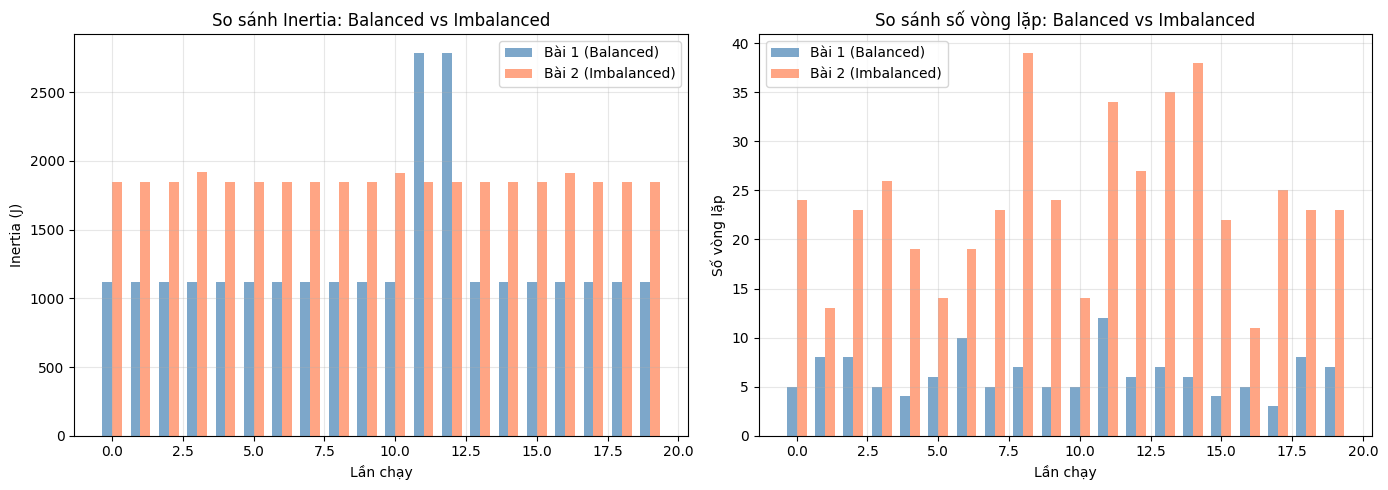

In [17]:
# Vẽ biểu đồ so sánh Bài 1 vs Bài 2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# So sánh Inertia
ax1 = axes[0]
x_pos = np.arange(n_runs)
width = 0.35
ax1.bar(x_pos - width/2, inertias_ex1, width, label="Bài 1 (Balanced)", color="steelblue", alpha=0.7)
ax1.bar(x_pos + width/2, inertias_ex2, width, label="Bài 2 (Imbalanced)", color="coral", alpha=0.7)
ax1.set_xlabel("Lần chạy")
ax1.set_ylabel("Inertia (J)")
ax1.set_title("So sánh Inertia: Balanced vs Imbalanced")
ax1.legend()
ax1.grid(True, alpha=0.3)

# So sánh số vòng lặp
ax2 = axes[1]
ax2.bar(x_pos - width/2, n_iters_ex1, width, label="Bài 1 (Balanced)", color="steelblue", alpha=0.7)
ax2.bar(x_pos + width/2, n_iters_list_ex2, width, label="Bài 2 (Imbalanced)", color="coral", alpha=0.7)
ax2.set_xlabel("Lần chạy")
ax2.set_ylabel("Số vòng lặp")
ax2.set_title("So sánh số vòng lặp: Balanced vs Imbalanced")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 2.6. Nhận xét về ảnh hưởng của kích thước cụm không cân bằng


1. **Ảnh hưởng đến việc phân cụm:**
   - K-means **KHÔNG THỂ** phân cụm đúng khi kích thước cụm chênh lệch lớn (50-20-1000)
   - Cụm lớn (1000 điểm) bị chia thành 2-3 cụm nhỏ hơn (499 và 449 điểm)
   - Các cụm nhỏ (50, 20 điểm) bị gộp lại với một phần của cụm lớn (122 điểm)
   - Kích thước cụm tìm được (122-499-449) khác xa kích thước thực (50-20-1000)

2. **Ảnh hưởng đến vị trí tâm cụm:**
   - Tâm cụm tìm được sai lệch đáng kể so với tâm thực:
     - Tâm thực: (2,2), (8,3), (3,6)
     - Tâm tìm được: (3.37, 3.01), (2.39, 5.80), (3.75, 6.58)
   - Không có tâm nào gần với tâm thực (8,3) của cụm 2 (20 điểm) - cụm này bị "nuốt" hoàn toàn

3. **So sánh với Bài 1 (Balanced):**
   - Inertia cao hơn nhiều: Mean = 1857.95 (Bài 2) vs 1288.25 (Bài 1)
   - Số vòng lặp nhiều hơn: Mean = 23.8 (Bài 2) vs 6.3 (Bài 1)
   - Độ ổn định tốt hơn: Std = 23.29 (Bài 2) vs 499.19 (Bài 1) - nhưng đây là ổn định ở kết quả SAI

4. **Kết luận:**
   - K-means **không hoạt động tốt**  với dữ liệu imbalanced
   - Lý do: K-means tối ưu hàm J = tổng bình phương khoảng cách. Cụm lớn đóng góp nhiều hơn vào J, nên thuật toán ưu tiên chia nhỏ cụm lớn thay vì giữ nguyên các cụm nhỏ
   - **Giải pháp:** Cân bằng dữ liệu trước khi clustering, sử dụng thuật toán khác (GMM, DBSCAN), hoặc dùng weighted K-means

### Assignment 3 (2 scores):

- Generate a toy dataset having $600$ data points, $200$ points of them following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma_1)$, $200$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma_1)$, and $200$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma_2)$ where

$$
    \Sigma_1 =
    \left(\begin{array}{cc}
        1 & 0 \\
        0 & 1
    \end{array}\right)
$$

and

$$
\Sigma_2 =
    \left(\begin{array}{cc}
        10 & 0 \\
        0 & 1
    \end{array}\right)
$$.

- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.
- Give comments on the effect of distribution $\mathcal{N}((3, 6), \Sigma_2)$ to the performance of K-means.

---
Dịch

- Tạo một tập dữ liệu mẫu gồm $600$ điểm dữ liệu, trong đó $200$ điểm tuân theo phân phối Gaussian $\mathcal{N}((2, 2), \Sigma_1)$, $200$ điểm tuân theo phân phối Gaussian $\mathcal{N}((8, 3), \Sigma_1)$, và $200$ điểm tuân theo phân phối Gaussian $\mathcal{N}((3, 6), \Sigma_2)$ với

$\Sigma_1 = \left(\begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array}\right)$ và $\Sigma_2 = \left(\begin{array}{cc} 10 & 0 \\ 0 & 1 \end{array}\right)$.

- Chỉ sử dụng Numpy để cài đặt phương pháp K-means nhằm tìm ba cụm từ tập dữ liệu mẫu.
- Huấn luyện K-means này với phương pháp EM.
- Đưa ra nhận xét về ảnh hưởng của phân phối $\mathcal{N}((3, 6), \Sigma_2)$ đến hiệu suất của K-means.

#### 3.1. Tạo dữ liệu mẫu (Different Variances)

Tạo dữ liệu với variance khác nhau giữa các cụm.
- Cụm 1, 2: Σ₁ = I (variance = 1)
- Cụm 3: Σ₂ = [[10, 0], [0, 1]] (variance_x = 10, hình elip)

Lưu ý: K-means giả định các cụm có dạng hình cầu (spherical).

In [18]:
# Reset seed
np.random.seed(42)

# Định nghĩa các tham số
mean1_ex3 = [2, 2]
mean2_ex3 = [8, 3]
mean3_ex3 = [3, 6]

# Ma trận hiệp phương sai KHÁC NHAU
cov1_ex3 = [[1, 0], [0, 1]]    # Σ₁: variance = 1 (hình tròn)
cov2_ex3 = [[10, 0], [0, 1]]   # Σ₂: variance_x = 10 (hình elip)

# Sinh dữ liệu
n_points_ex3 = 200
X1_ex3 = np.random.multivariate_normal(mean1_ex3, cov1_ex3, n_points_ex3)  # Σ₁
X2_ex3 = np.random.multivariate_normal(mean2_ex3, cov1_ex3, n_points_ex3)  # Σ₁
X3_ex3 = np.random.multivariate_normal(mean3_ex3, cov2_ex3, n_points_ex3)  # Σ₂ (elip)

# Ghép dữ liệu
X_ex3 = np.vstack([X1_ex3, X2_ex3, X3_ex3])

# Nhãn thực
y_true_ex3 = np.array([0]*n_points_ex3 + [1]*n_points_ex3 + [2]*n_points_ex3)

print(f"Kích thước dữ liệu: {X_ex3.shape}")
print(f"Số điểm mỗi cụm: {n_points_ex3}")
print(f"\nMa trận hiệp phương sai:")
print(f"  Cụm 1, 2: Σ₁ = {cov1_ex3}")
print(f"  Cụm 3: Σ₂ = {cov2_ex3} (variance_x gấp 10 lần)")

Kích thước dữ liệu: (600, 2)
Số điểm mỗi cụm: 200

Ma trận hiệp phương sai:
  Cụm 1, 2: Σ₁ = [[1, 0], [0, 1]]
  Cụm 3: Σ₂ = [[10, 0], [0, 1]] (variance_x gấp 10 lần)


#### 3.2. Trực quan hóa dữ liệu ban đầu

- Quan sát cụm 3 (màu xanh lá) có dạng hình elip kéo dài theo trục x.

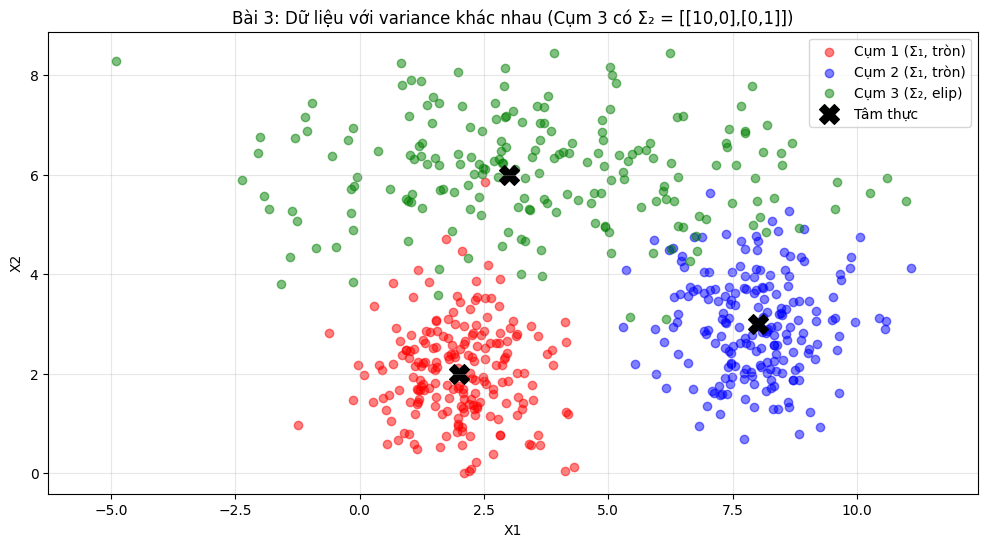

In [19]:
plt.figure(figsize=(12, 6))

# Vẽ các điểm dữ liệu
plt.scatter(X1_ex3[:, 0], X1_ex3[:, 1], c="red", alpha=0.5, label="Cụm 1 (Σ₁, tròn)")
plt.scatter(X2_ex3[:, 0], X2_ex3[:, 1], c="blue", alpha=0.5, label="Cụm 2 (Σ₁, tròn)")
plt.scatter(X3_ex3[:, 0], X3_ex3[:, 1], c="green", alpha=0.5, label="Cụm 3 (Σ₂, elip)")

# Đánh dấu tâm thực
true_centers_ex3 = np.array([mean1_ex3, mean2_ex3, mean3_ex3])
plt.scatter(true_centers_ex3[:, 0], true_centers_ex3[:, 1], c="black", marker="X", s=200, label="Tâm thực")

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Bài 3: Dữ liệu với variance khác nhau (Cụm 3 có Σ₂ = [[10,0],[0,1]])")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis("equal")  # Giữ tỷ lệ để thấy rõ hình elip
plt.show()

#### 3.3. Chạy thuật toán K-means

- K-means sử dụng khoảng cách Euclidean, giả định các cụm có dạng hình cầu.

In [20]:
# Chạy K-means
np.random.seed(42)
K = 3
cent_hist_ex3, lab_hist_ex3, n_iters_ex3 = kmeans(X_ex3, K)

# Kết quả cuối cùng
final_centroids_ex3 = cent_hist_ex3[-1]
final_labels_ex3 = lab_hist_ex3[-1]

print(f"\nSố vòng lặp: {n_iters_ex3}")
print(f"\nTâm cụm tìm được:\n{final_centroids_ex3}")
print(f"\nTâm thực:\n{true_centers_ex3}")
print(f"\nInertia (J): {compute_inertia(X_ex3, final_labels_ex3, final_centroids_ex3):.2f}")

# Đếm số điểm trong mỗi cụm
print(f"\nSố điểm trong mỗi cụm tìm được:")
for i in range(K):
    print(f"  Cụm {i+1}: {np.sum(final_labels_ex3 == i)} điểm")

Hội tụ sau 5 vòng lặp!

Số vòng lặp: 5

Tâm cụm tìm được:
[[1.96713809 2.05011551]
 [7.82773082 3.52419383]
 [2.44220016 6.25733703]]

Tâm thực:
[[2 2]
 [8 3]
 [3 6]]

Inertia (J): 1985.32

Số điểm trong mỗi cụm tìm được:
  Cụm 1: 203 điểm
  Cụm 2: 250 điểm
  Cụm 3: 147 điểm


#### 3.4. Trực quan hóa kết quả phân cụm

- Quan sát xem K-means có phân cụm đúng cụm hình elip không.

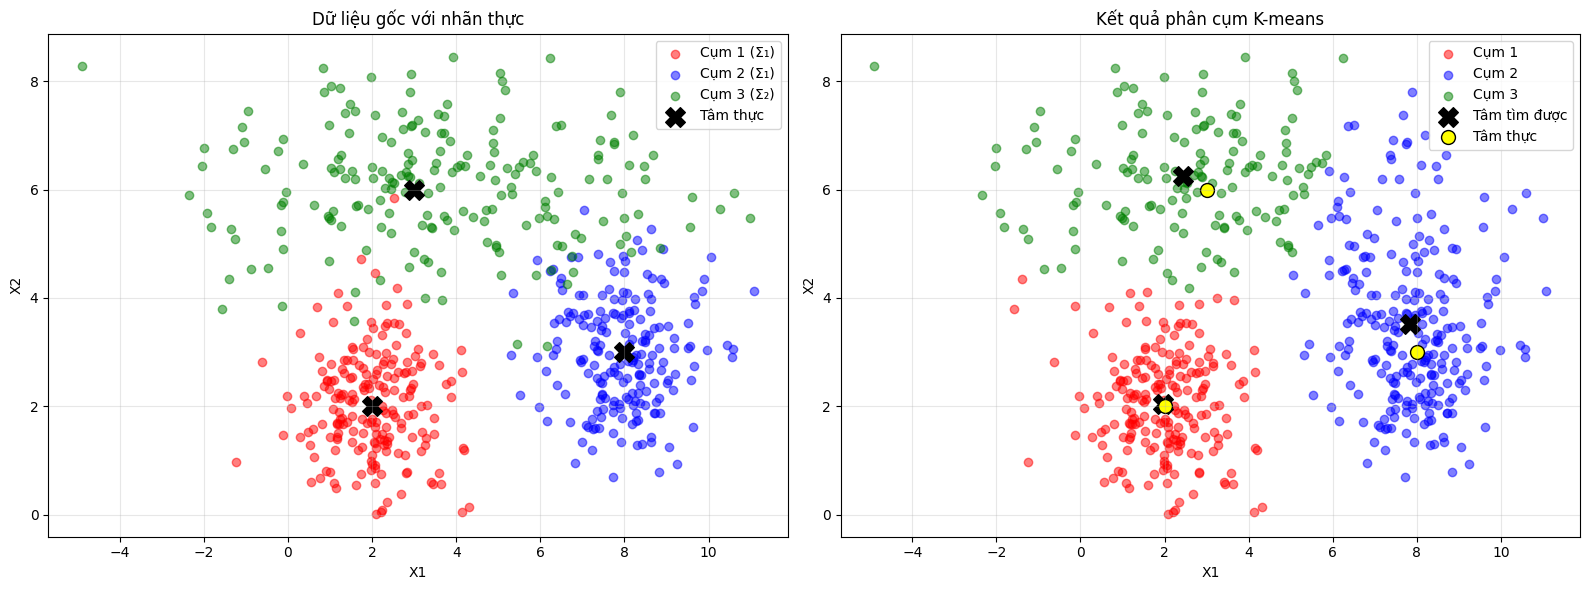

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = ["red", "blue", "green"]

# Subplot 1: Dữ liệu gốc
ax1 = axes[0]
ax1.scatter(X1_ex3[:, 0], X1_ex3[:, 1], c="red", alpha=0.5, label="Cụm 1 (Σ₁)")
ax1.scatter(X2_ex3[:, 0], X2_ex3[:, 1], c="blue", alpha=0.5, label="Cụm 2 (Σ₁)")
ax1.scatter(X3_ex3[:, 0], X3_ex3[:, 1], c="green", alpha=0.5, label="Cụm 3 (Σ₂)")
ax1.scatter(true_centers_ex3[:, 0], true_centers_ex3[:, 1], c="black", marker="X", s=200, label="Tâm thực")
ax1.set_xlabel("X1")
ax1.set_ylabel("X2")
ax1.set_title("Dữ liệu gốc với nhãn thực")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: Kết quả K-means
ax2 = axes[1]
for i in range(K):
    mask = final_labels_ex3 == i
    ax2.scatter(X_ex3[mask, 0], X_ex3[mask, 1], c=colors[i], alpha=0.5, label=f"Cụm {i+1}")
ax2.scatter(final_centroids_ex3[:, 0], final_centroids_ex3[:, 1], c="black", marker="X", s=200, label="Tâm tìm được")
ax2.scatter(true_centers_ex3[:, 0], true_centers_ex3[:, 1], c="yellow", marker="o", s=100, edgecolors="black", label="Tâm thực")
ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
ax2.set_title("Kết quả phân cụm K-means")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 3.5. Đánh giá ảnh hưởng của variance khác nhau

- Chạy K-means nhiều lần và phân tích kết quả.

- Lưu ý: K-means có thể chia cụm hình elip thành nhiều cụm nhỏ hơn.

In [22]:
# Chạy K-means nhiều lần
n_runs = 20
results_ex3 = []

print("Chạy K-means 20 lần trên dữ liệu có variance khác nhau...\n")

for run in range(n_runs):
    np.random.seed(run)
    cent_hist, lab_hist, n_iter = kmeans(X_ex3, K, verbose=False)

    final_cent = cent_hist[-1]
    final_lab = lab_hist[-1]
    inertia = compute_inertia(X_ex3, final_lab, final_cent)

    cluster_sizes = [np.sum(final_lab == i) for i in range(K)]

    results_ex3.append({
        "run": run + 1,
        "n_iters": n_iter,
        "inertia": inertia,
        "cluster_sizes": cluster_sizes,
        "centroids": final_cent
    })

# Hiển thị kết quả
print(f"{'Lần':^6} | {'Iters':^6} | {'Inertia':^12} | {'Kích thước cụm':^20}")
print("=" * 55)
for r in results_ex3:
    sizes_str = f"{r['cluster_sizes'][0]}-{r['cluster_sizes'][1]}-{r['cluster_sizes'][2]}"
    print(f"{r['run']:^6} | {r['n_iters']:^6} | {r['inertia']:^12.2f} | {sizes_str:^20}")

Chạy K-means 20 lần trên dữ liệu có variance khác nhau...

 Lần   | Iters  |   Inertia    |    Kích thước cụm   
  1    |   7    |   1985.76    |     147-205-248     
  2    |   10   |   1985.76    |     147-248-205     
  3    |   8    |   1985.32    |     250-203-147     
  4    |   8    |   1985.42    |     147-249-204     
  5    |   8    |   1985.32    |     147-203-250     
  6    |   13   |   1985.76    |     205-147-248     
  7    |   13   |   1985.76    |     205-248-147     
  8    |   6    |   1985.32    |     250-203-147     
  9    |   8    |   1985.32    |     250-147-203     
  10   |   7    |   1985.76    |     147-205-248     
  11   |   6    |   1985.32    |     203-250-147     
  12   |   14   |   1985.76    |     248-147-205     
  13   |   16   |   1985.76    |     205-248-147     
  14   |   14   |   1985.76    |     147-248-205     
  15   |   5    |   1985.76    |     248-205-147     
  16   |   5    |   1985.32    |     203-147-250     
  17   |   7    |   198

In [23]:
# Thống kê và so sánh
inertias_ex3 = [r["inertia"] for r in results_ex3]
n_iters_list_ex3 = [r["n_iters"] for r in results_ex3]

print("THỐNG KÊ KẾT QUẢ BÀI 3 (Different Variances):")
print(f"Inertia - Min: {min(inertias_ex3):.2f}, Max: {max(inertias_ex3):.2f}, Mean: {np.mean(inertias_ex3):.2f}, Std: {np.std(inertias_ex3):.2f}")
print(f"Số vòng lặp - Min: {min(n_iters_list_ex3)}, Max: {max(n_iters_list_ex3)}, Mean: {np.mean(n_iters_list_ex3):.1f}")

print(f"\n--- SO SÁNH 3 BÀI ---")
print(f"Bài 1 (Balanced, same Σ):     Inertia mean = {np.mean(inertias_ex1):.2f}, std = {np.std(inertias_ex1):.2f}")
print(f"Bài 2 (Imbalanced, same Σ):   Inertia mean = {np.mean(inertias_ex2):.2f}, std = {np.std(inertias_ex2):.2f}")
print(f"Bài 3 (Balanced, diff Σ):     Inertia mean = {np.mean(inertias_ex3):.2f}, std = {np.std(inertias_ex3):.2f}")

THỐNG KÊ KẾT QUẢ BÀI 3 (Different Variances):
Inertia - Min: 1985.32, Max: 1985.76, Mean: 1985.58, Std: 0.21
Số vòng lặp - Min: 4, Max: 16, Mean: 8.9

--- SO SÁNH 3 BÀI ---
Bài 1 (Balanced, same Σ):     Inertia mean = 1288.25, std = 499.19
Bài 2 (Imbalanced, same Σ):   Inertia mean = 1857.95, std = 23.29
Bài 3 (Balanced, diff Σ):     Inertia mean = 1985.58, std = 0.21


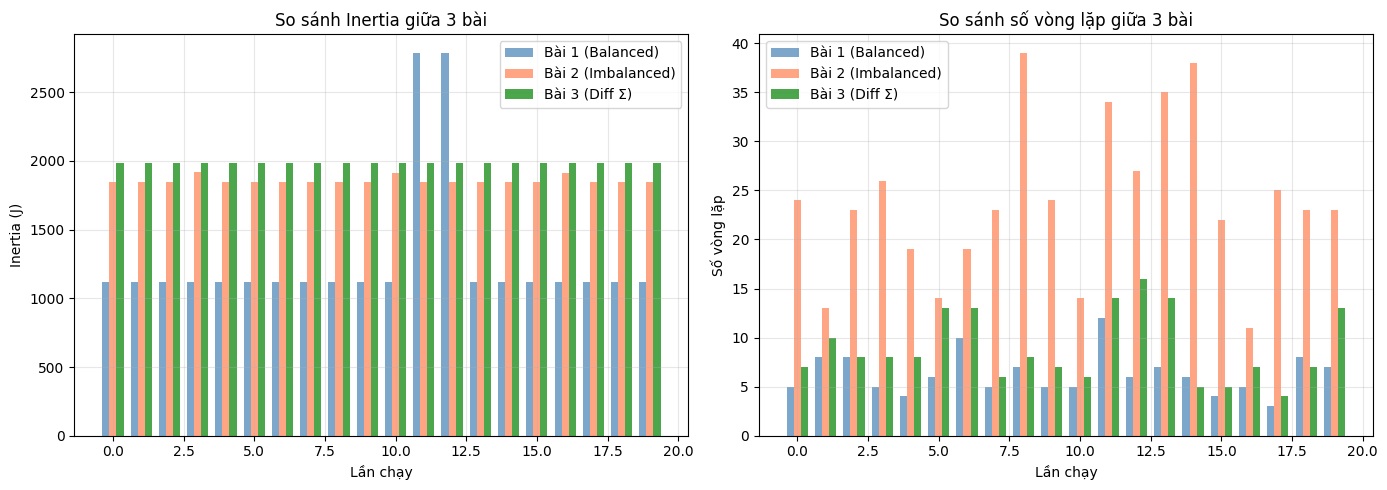

In [24]:
# Vẽ biểu đồ so sánh 3 bài
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# So sánh Inertia
ax1 = axes[0]
x_pos = np.arange(n_runs)
width = 0.25
ax1.bar(x_pos - width, inertias_ex1, width, label="Bài 1 (Balanced)", color="steelblue", alpha=0.7)
ax1.bar(x_pos, inertias_ex2, width, label="Bài 2 (Imbalanced)", color="coral", alpha=0.7)
ax1.bar(x_pos + width, inertias_ex3, width, label="Bài 3 (Diff Σ)", color="green", alpha=0.7)
ax1.set_xlabel("Lần chạy")
ax1.set_ylabel("Inertia (J)")
ax1.set_title("So sánh Inertia giữa 3 bài")
ax1.legend()
ax1.grid(True, alpha=0.3)

# So sánh số vòng lặp
ax2 = axes[1]
ax2.bar(x_pos - width, n_iters_ex1, width, label="Bài 1 (Balanced)", color="steelblue", alpha=0.7)
ax2.bar(x_pos, n_iters_list_ex2, width, label="Bài 2 (Imbalanced)", color="coral", alpha=0.7)
ax2.bar(x_pos + width, n_iters_list_ex3, width, label="Bài 3 (Diff Σ)", color="green", alpha=0.7)
ax2.set_xlabel("Lần chạy")
ax2.set_ylabel("Số vòng lặp")
ax2.set_title("So sánh số vòng lặp giữa 3 bài")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 3.6. Phân tích chi tiết ảnh hưởng của cụm hình elip

-  Phân tích xem cụm 3 (hình elip) bị phân cụm như thế nào.

- Lưu ý: Kiểm tra xem các điểm ở hai đầu của elip có bị gán vào cụm khác không.

In [25]:
# Phân tích chi tiết: Bao nhiêu điểm của cụm 3 (elip) bị gán sai?
np.random.seed(42)
cent_hist, lab_hist, _ = kmeans(X_ex3, K, verbose=False)
final_lab = lab_hist[-1]

# Lấy nhãn của các điểm thuộc cụm 3 thực
cluster3_true_indices = np.where(y_true_ex3 == 2)[0]
cluster3_predicted_labels = final_lab[cluster3_true_indices]

# Đếm số điểm bị gán vào mỗi cụm
print("Phân tích cụm 3 (hình elip, 200 điểm):")
for i in range(K):
    count = np.sum(cluster3_predicted_labels == i)
    print(f"  Số điểm bị gán vào cụm {i+1}: {count} ({count/200*100:.1f}%)")

# Tương tự cho cụm 1 và 2
print(f"\nPhân tích cụm 1 (hình tròn, 200 điểm):")
cluster1_predicted = final_lab[y_true_ex3 == 0]
for i in range(K):
    count = np.sum(cluster1_predicted == i)
    print(f"  Số điểm bị gán vào cụm {i+1}: {count} ({count/200*100:.1f}%)")

print(f"\nPhân tích cụm 2 (hình tròn, 200 điểm):")
cluster2_predicted = final_lab[y_true_ex3 == 1]
for i in range(K):
    count = np.sum(cluster2_predicted == i)
    print(f"  Số điểm bị gán vào cụm {i+1}: {count} ({count/200*100:.1f}%)")

Phân tích cụm 3 (hình elip, 200 điểm):
  Số điểm bị gán vào cụm 1: 7 (3.5%)
  Số điểm bị gán vào cụm 2: 50 (25.0%)
  Số điểm bị gán vào cụm 3: 143 (71.5%)

Phân tích cụm 1 (hình tròn, 200 điểm):
  Số điểm bị gán vào cụm 1: 196 (98.0%)
  Số điểm bị gán vào cụm 2: 0 (0.0%)
  Số điểm bị gán vào cụm 3: 4 (2.0%)

Phân tích cụm 2 (hình tròn, 200 điểm):
  Số điểm bị gán vào cụm 1: 0 (0.0%)
  Số điểm bị gán vào cụm 2: 200 (100.0%)
  Số điểm bị gán vào cụm 3: 0 (0.0%)


#### 3.7. Nhận xét về ảnh hưởng của phân phối có variance khác nhau


**NHẬN XÉT BÀI 3:**

1. **Ảnh hưởng của cụm hình elip (Σ₂) đến việc phân cụm:**
   - Cụm 3 (hình elip, 200 điểm) bị phân tán vào nhiều cụm khác nhau:
     - Chỉ 71.5% (143 điểm) được gán đúng vào cụm 3
     - 25% (50 điểm) bị gán nhầm vào cụm 2
     - 3.5% (7 điểm) bị gán nhầm vào cụm 1
   - Các điểm ở hai đầu của elip (theo trục x) bị gán vào các cụm khác do khoảng cách Euclidean xa tâm
   - Cụm 1 và 2 (hình tròn) được phân cụm tốt hơn: Cụm 1 đạt 98%, Cụm 2 đạt 100%

2. **Ảnh hưởng đến vị trí tâm cụm:**
   - Tâm cụm 1 và 2 tìm được khá gần tâm thực:
     - Tâm 1: (1.97, 2.05) vs thực (2, 2)
     - Tâm 2: (7.83, 3.52) vs thực (8, 3)
   - Tâm cụm 3 bị lệch: (2.44, 6.26) vs thực (3, 6) - lệch về phía trái do mất các điểm ở đầu phải của elip

3. **So sánh với Bài 1 (cùng variance):**
   - Inertia cao hơn: Mean ≈ 1985.5 (Bài 3) vs 1288.25 (Bài 1) - do cụm elip có variance lớn
   - Số vòng lặp tương đương: Mean ≈ 8.5 (Bài 3) vs 6.3 (Bài 1)
   - Độ ổn định rất cao: Std ≈ 0.2 (Bài 3) vs 499.19 (Bài 1) - tất cả 20 lần đều hội tụ về cùng một nghiệm
   - Kích thước cụm dao động nhẹ (147-205-248) nhưng tổng luôn = 600

4. **Kết luận:**
   - K-means **hoạt động không tốt** với cụm có hình dạng không phải hình cầu (elip)
   - Lý do: K-means sử dụng khoảng cách Euclidean, giả định các cụm có dạng spherical (hình cầu) với variance bằng nhau
   - Cụm elip bị "cắt" ở hai đầu vì các điểm xa tâm theo trục x bị gán vào cụm khác
   - **Giải pháp:** Sử dụng GMM (có thể học được ma trận covariance), DBSCAN (density-based), hoặc chuẩn hóa dữ liệu (standardization) trước khi clustering

---
### Tổng kết

In [26]:
# Bảng tổng kết
print("=" * 80)
print(f"{'Bài':^6} | {'Đặc điểm dữ liệu':^30} | {'Inertia Mean':^15} | {'Inertia Std':^12}")
print("=" * 80)
print(f"{'1':^6} | {'Balanced (200-200-200), same Σ':^30} | {np.mean(inertias_ex1):^15.2f} | {np.std(inertias_ex1):^12.2f}")
print(f"{'2':^6} | {'Imbalanced (50-20-1000), same Σ':^30} | {np.mean(inertias_ex2):^15.2f} | {np.std(inertias_ex2):^12.2f}")
print(f"{'3':^6} | {'Balanced (200-200-200), diff Σ':^30} | {np.mean(inertias_ex3):^15.2f} | {np.std(inertias_ex3):^12.2f}")
print("=" * 80)

 Bài   |        Đặc điểm dữ liệu        |  Inertia Mean   | Inertia Std 
  1    | Balanced (200-200-200), same Σ |     1288.25     |    499.19   
  2    | Imbalanced (50-20-1000), same Σ |     1857.95     |    23.29    
  3    | Balanced (200-200-200), diff Σ |     1985.58     |     0.21    


**TỔNG KẾT CHUNG:**

| Bài | Đặc điểm dữ liệu | Inertia Mean | Inertia Std | Nhận xét |
|:---:|:----------------|:------------:|:-----------:|:---------|
| 1 | Balanced (200-200-200), same Σ | 1288.25 | 499.19 | 90% tìm được nghiệm tối ưu |
| 2 | Imbalanced (50-20-1000), same Σ | 1857.95 | 23.29 | Phân cụm sai hoàn toàn |
| 3 | Balanced (200-200-200), diff Σ | 1985.58 | 0.21 | Cụm elip bị cắt ~28.5% |

1. **Bài 1 - Ảnh hưởng của khởi tạo ngẫu nhiên:**
   - Khởi tạo ngẫu nhiên **có ảnh hưởng** đến kết quả (10% rơi vào local minimum với J gấp 2.5 lần)
   - Với dữ liệu lý tưởng (balanced, same variance, tách biệt), K-means vẫn hoạt động tốt trong đa số trường hợp

2. **Bài 2 - Ảnh hưởng của kích thước cụm không cân bằng:**
   - K-means **không thành công** với dữ liệu imbalanced (50-20-1000)
   - Cụm lớn bị chia nhỏ, cụm nhỏ bị "nuốt" - không có cụm nào được phân đúng
   - Nguyên nhân: Hàm mục tiêu J ưu tiên giảm thiểu tổng khoảng cách, cụm lớn đóng góp nhiều hơn

3. **Bài 3 - Ảnh hưởng của variance khác nhau:**
   - K-means **hoạt động không tốt** với cụm có hình dạng elip (variance khác nhau theo các trục)
   - Cụm hình tròn được phân đúng (98-100%), cụm elip chỉ đạt 71.5%
   - Nguyên nhân: K-means giả định các cụm có dạng spherical với variance bằng nhau

4. **Hạn chế của K-means:**
   - Nhạy cảm với khởi tạo ngẫu nhiên → có thể rơi vào local minimum
   - Không hoạt động tốt với dữ liệu imbalanced → cụm lớn bị chia, cụm nhỏ bị gộp
   - Giả định các cụm có dạng hình cầu (spherical) → không phù hợp với cụm elip
   - Cần biết trước số cụm K → khó xác định trong thực tế

5. **Giải pháp:**
   - **K-means++:** Khởi tạo tâm cụm thông minh hơn, giảm xác suất rơi vào local minimum
   - **Chạy nhiều lần:** Chọn kết quả có Inertia nhỏ nhất
   - **GMM (Gaussian Mixture Model):** Có thể học được ma trận covariance, phù hợp với cụm elip
   - **DBSCAN:** Density-based, không cần biết trước K, phù hợp với dữ liệu có hình dạng phức tạp
   - **Chuẩn hóa dữ liệu:** Standardization trước khi clustering để các feature có cùng scale